# Perform sentimental analysis on the Elon-musk tweets (Elon-musk.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import re
import unicodedata
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import nltk # Natural Language Toolkit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import files


uploaded = files.upload()


Saving Elon_musk.csv to Elon_musk (1).csv


Checking encoding of file

In [5]:
import chardet

with open('Elon_musk.csv','rb') as f:
  data = f.read()
  encoding=chardet.detect(data).get('encoding')
  print(encoding)

Windows-1252


In [6]:
data = pd.read_csv('/content/Elon_musk.csv',encoding='windows-1252',index_col=0)

# **Exploring Data**

In [7]:
data.head()

,Text
1,@kunalb11 I’m an alien
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
3,@joerogan @Spotify Great interview!
4,@gtera27 Doge is underestimated
5,@teslacn Congratulations Tesla China for amazi...


In [8]:
data.shape

(1999, 1)

<Axes: xlabel='Text', ylabel='Count'>

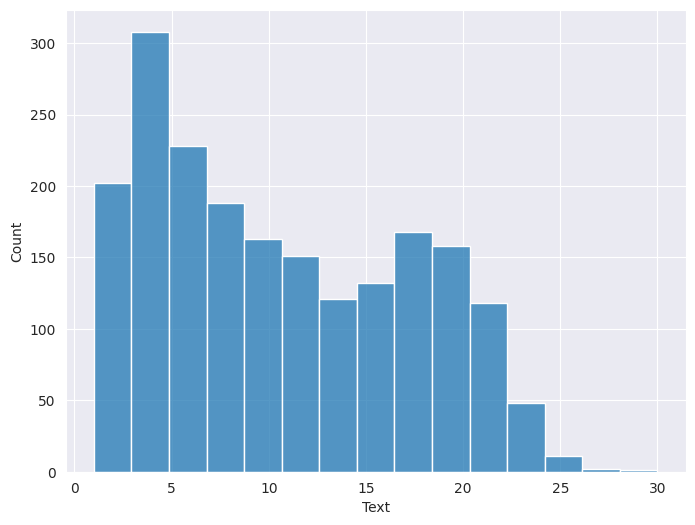

In [9]:
plt.figure(figsize=(8,6))
word_count = data['Text'].apply(lambda x:len(str(x).split(" ")))
sns.histplot(word_count)

In [10]:
data['Text'][201]

'RT @SpaceX: Falcon 9’s first stage has landed on the Of Course I Still Love You droneship https://t.co/6gWWlLiXdG'

In [11]:
data['Text'][1995]

'@flcnhvy True, it sounds so surreal, but the negative propaganda is still all out there &amp; easy to find in social me… https://t.co/WJRzIbKh1H'

# **Separating usernames and actual tweets**

<Axes: xlabel='0'>

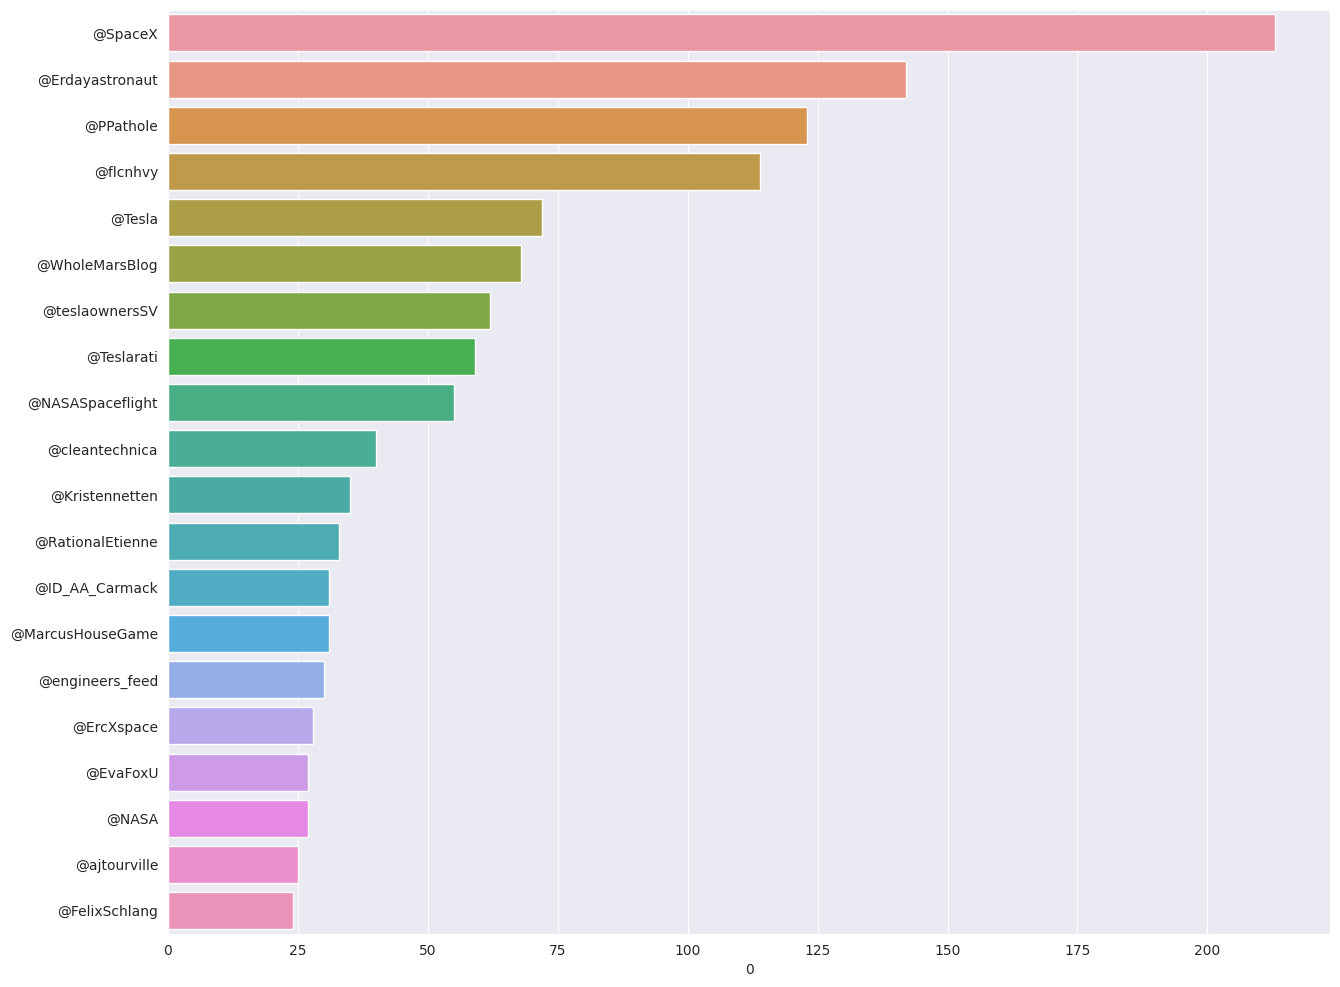

In [12]:
all_usernames = data['Text'].str.extractall(r'(@\w+)')[0].value_counts()
plt.figure(figsize=(15,12))
sns.barplot(y=all_usernames.head(20).index,x=all_usernames.head(20))

In [13]:
# data['tweet'] = data['Text'].apply(lamda tweet: re.sub(r'@\w+\s*',))
data['tweet'] = data['Text'].str.replace(r'@\w+\s*','',regex=True).str.strip()

In [14]:
'''
def separate_usernames(tweet):
    usernmae = []
    words = tweet.split()
    other_words = []
    for word in words:
        if word.startswith('@'):
           usernames.append(word)
        else:
            other_words.append(word)
   return usernames, other_words
data[['usernames','other_words']] = dat['Text].apply(seperate_usernames)
'''
data['usernames'] = data['Text'].apply(lambda tweet:[word for word in tweet.split()if word.startswith('@')])


In [15]:
data.head()

,Text,tweet,usernames
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11]
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack]
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]"
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27]
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...,[@teslacn]


Separating links from tweets

In [16]:
data['tweet'].str.contains(r'http[s]?://[^\s]+',regex=True).value_counts()

False    1356
True      643
Name: tweet, dtype: int64

In [17]:
data['tweet'] = data['tweet'].str.replace(r'http[s]?://[^\s]+', '',regex=True).str.strip()

In [18]:
data.head()

,Text,tweet,usernames
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11]
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack]
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]"
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27]
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...,[@teslacn]


### **Identifying and Extracting text from emojis**

In [19]:
def decode_emojis(text):
    hex_code = re.findall(r'<U\+([0-9A-Fa-f]+)>', text)
    if hex_code:
        code_point = int(hex_code[0],16)
        decode_text = chr(code_point)
        return unicodedata.name(decode_text)
    else:
       return np.nan

data['emojis'] = data['tweet'].apply(decode_emojis)

In [20]:
data['tweet'] = data['tweet'].str.replace(r'<U\+[\w]+>','',regex=True).str.strip()

## **Adding text extracted from emojis to tweets**

In [21]:
data['tweet'] = data['tweet']+' '+data['emojis'].fillna('')

In [22]:
data.head()

,Text,tweet,usernames,emojis
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11],NaN
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack],NaN
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]",NaN
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27],NaN
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...,[@teslacn],NaN


## **Removing retweet tag 'RT'**

In [23]:
data['tweet'].str.startswith('RT').sum()

127

In [24]:
data['tweet'] = data['tweet'].str.replace('RT:','').str.strip()

## **Top Named Entities**

In [25]:
def extract_named_entities(tweet):
    doc = nlp(tweet)
    entities = [entity.text for entity in doc.ents]
    return entities

name_list = data['tweet'].apply(extract_named_entities)
name_list = [entity for sublist in name_list for entity in sublist]


<Axes: >

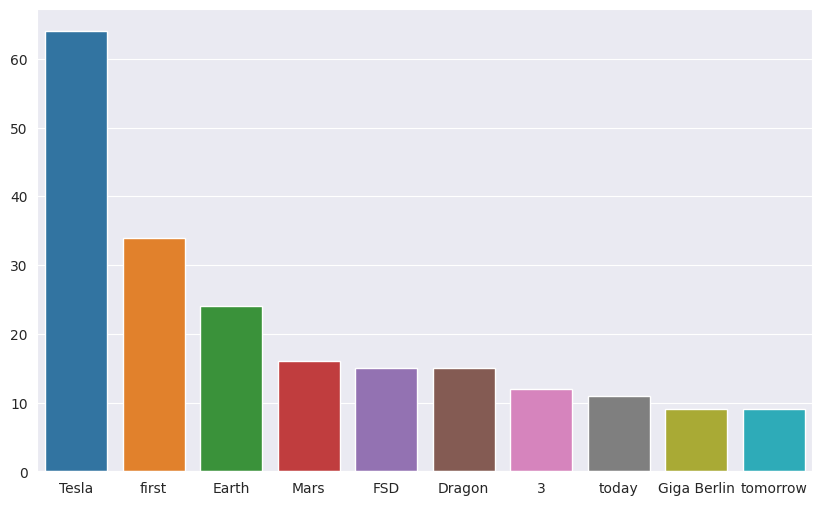

In [26]:
entity_counts = Counter(name_list)
top_10_names = [entity[0] for entity in entity_counts.most_common(10)]
top_10_counts = [entity[1] for entity in entity_counts.most_common(10)]
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_names,y=top_10_counts)

In [27]:
def remove_named_entities(text):
    for word in top_10_names:
        return re.sub(word,'',text)
data['tweet'] = data['tweet'].apply(remove_named_entities)

## **Removing punctuation,numbers,speciacl characters**

tweet with\n string

In [28]:
data['tweet'].str.contains('\n').sum()

40

In [29]:
# tweetswith [] strings
data['tweet'].str.contains(r'\[.*?\]').sum()

2

In [30]:
# Tweets with special characters and numbers
data['tweet'].str.contains(r'[^\w\s]|[\d]').sum()

1261

In [31]:
data['cleaned_tweet'] = data['tweet'].str.replace(r'\n|[^\w\s]|[\d]|\[.*.?\]','',regex=True)

In [32]:
#Lowercasing all letters
data['clened_tweet'] = data['cleaned_tweet'].str.lower()


In [33]:
# Removing stopwords
from google.colab import files


uploaded = files.upload()

Saving stop.txt to stop.txt


In [34]:
stop = stopwords.words('english')

with open('stop.txt')as f:
     extra_stop = [word.strip('\n')for word in f. readlines()]

stop.extend(extra_stop)
stop.extend(['im','ur','et','st','amp','rolling','floor'])

In [35]:
data['without_stopwords'] = data['cleaned_tweet'].apply(lambda x: [x for x in x.split() if x not in stop])

In [36]:
# stemmer = PorterStemmer()
# data['without_stopwords'].apply(lambda x: [stem(i) for i in x ])

**Lemmatization**

In [37]:
lemmatizer = WordNetLemmatizer()
data['lemmatized_tweet'] = data['without_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x]))

## **Sentiment Analysis**

In [38]:
sia = SentimentIntensityAnalyzer()

data['score'] = data['lemmatized_tweet'].apply(lambda tweet: sia.polarity_scores(tweet)['compound'])
data['sentiment'] = data['score'].apply(lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral')

In [39]:
data.head()

,Text,tweet,usernames,emojis,cleaned_tweet,clened_tweet,without_stopwords,lemmatized_tweet,score,sentiment
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11],NaN,Im an alien,im an alien,"[Im, alien]",Im alien,0.0000,Neutral
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack],NaN,Ray tracing on Cyberpunk with HDR is nextlevel...,ray tracing on cyberpunk with hdr is nextlevel...,"[Ray, tracing, Cyberpunk, HDR, nextlevel, Have]",Ray tracing Cyberpunk HDR nextlevel Have,0.0000,Neutral
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]",NaN,Great interview,great interview,"[Great, interview]",Great interview,0.6249,Positive
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27],NaN,Doge is underestimated,doge is underestimated,"[Doge, underestimated]",Doge underestimated,-0.2732,Negative
5,@teslacn Congratulations Tesla China for amazi...,Congratulations China for amazing execution l...,[@teslacn],NaN,Congratulations China for amazing execution l...,congratulations china for amazing execution l...,"[Congratulations, China, amazing, execution, y...",Congratulations China amazing execution year Now,0.8271,Positive


<Axes: xlabel='sentiment', ylabel='count'>

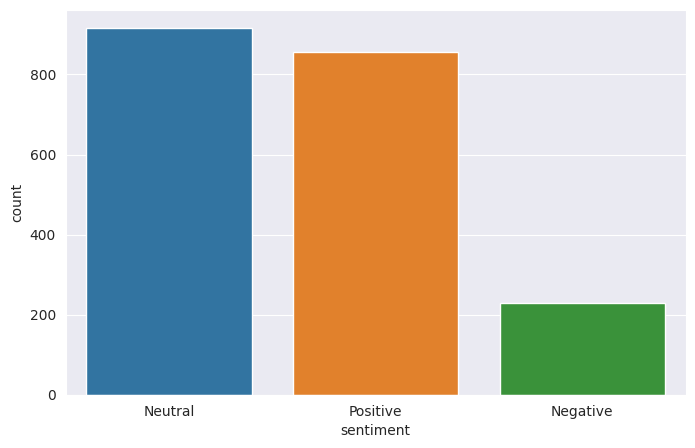

In [40]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='sentiment')

Most common words in positive comments

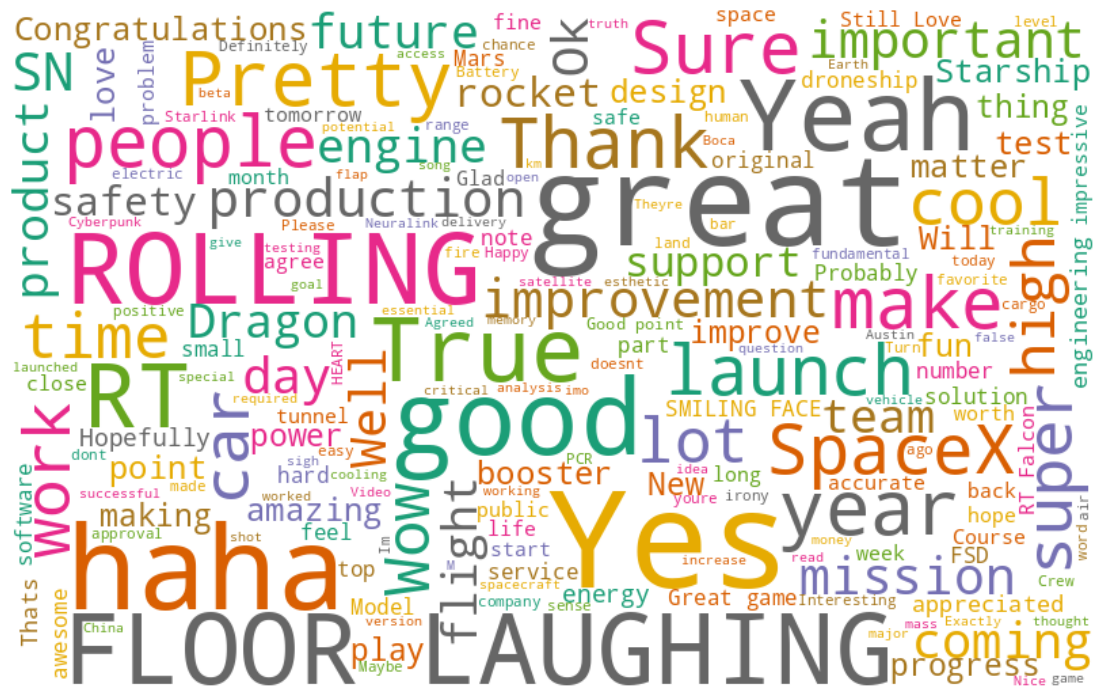

In [41]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2',background_color='white').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
all_words = ' '.join([text for text in data[data['sentiment']=='Positive']['lemmatized_tweet']])
generate_wordcloud(all_words)

Most common words in negative **tweet**

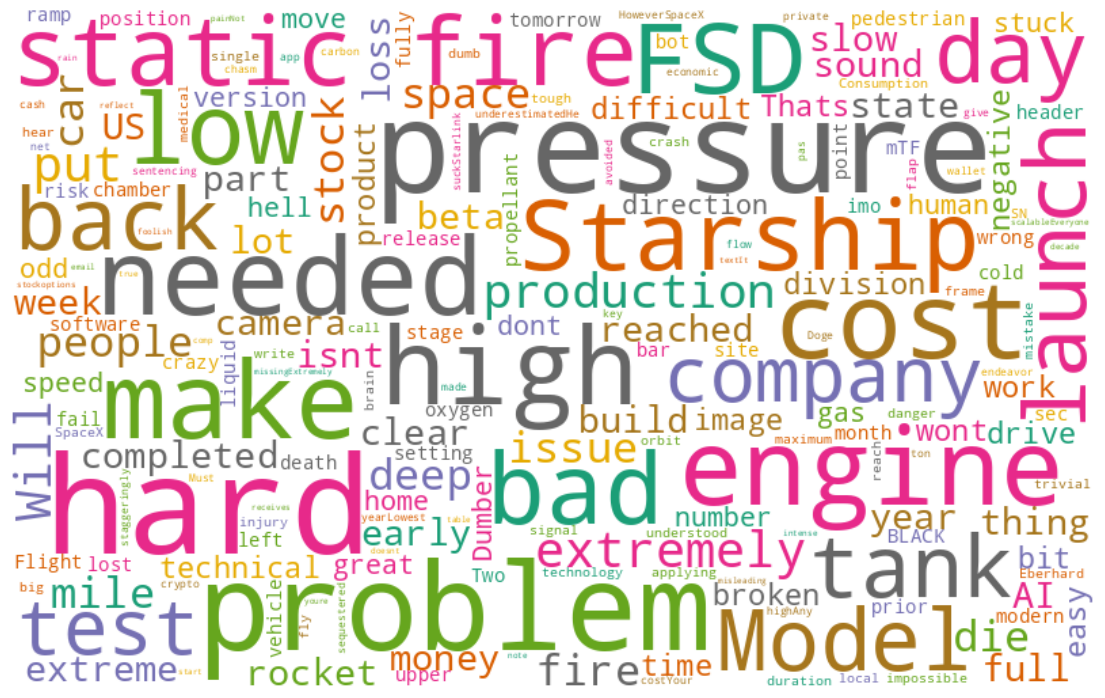

In [42]:
all_words = ''.join([text for text in data[data['sentiment']=='Negative']['lemmatized_tweet']])
generate_wordcloud(all_words)

**Feature Extraction for key words**

TF-IDF (Team Frequency-inverse Document Frequency)

In [43]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf_features = vectorizer.fit_transform(data['lemmatized_tweet'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(),
                       columns=vectorizer.get_feature_names_out())

In [44]:
tfidf_df.head()

,abort,absolutely,absurd,acceptable,access,accurate,achieve,active,actual,actually,...,yeah,year,yes,yesterday,youd,youre,youve,yup,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.394729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
target_variable = data['sentiment'].apply(lambda x: 0 if x=='Negative' else 1)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df,target_variable, test_size=0.3)

# Model Building

In [47]:
classifier = MultinomialNB()
classifier.fit(x_train,y_train)

MultinomialNB()

In [48]:
y_pred = classifier.predict(x_test)

In [49]:
confusion_matrix(y_test,y_pred,labels=[True,False])

array([[548,   0],
       [ 52,   0]])

# Accuracy

In [50]:
accuracy_score(y_test,y_pred)*100

91.33333333333333